# Strategy 1

In this case, we set $f_\phi$ to all the channels.

In [1]:
using PyPlot
using Roots
using NLsolve
using DataFrames
using CSV
using PyCall


In [3]:
include("./src/lattice_data.jl")
include("./src/latt_para.jl")
include("./src/tmat_finite_vol.jl")
include("./src/tmat_finite_vol_nlo.jl")
include("./src/tmat.jl")
include("./gauss_quad/gaussian_quad.jl")
include("./src/CL_1sigma_LO.jl")

Λ1405_1σ! (generic function with 1 method)

In [4]:
latt_para = lattice_params()

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

# 4 energy levels

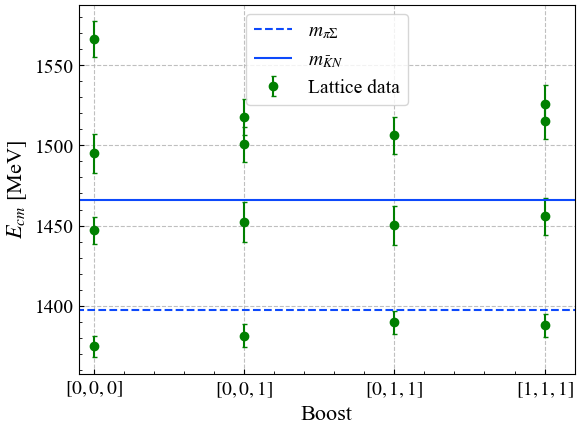

In [4]:
fig, ax = PyPlot.subplots()
#plot_theory_ener_2level!(ax, pole)
plot_latt_ener!(ax, latt_pole, latt_pole_err, latt_para[:threshold] )
ax.grid()
gcf()

We try to fit to all energy levels.

In [5]:
params = copy(latt_para )

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

In [7]:
function cost_fun!(latt_pole, latt_pole_err, params, Nv, fitted_para; dof=2,  same_f=true)
    params_copy = copy(params)
    if same_f == true
        a1, a2, fπ, f = fitted_para
        
        params_copy[:decons_vec] = [fπ, fπ] .* f
    else
        a1, a2 = fitted_para
    end

    dd = 0e0
    len = 0e0
    for (pole, pole_err, N) in zip(latt_pole, latt_pole_err, Nv)
        x0 = (N == [0, 0, 1] || N == [1, 1, 1] ? bisection_pole_finite_vol!(params_copy, [a1, a2], N) : [pole_finite_vol!(init_x, params_copy, [a1, a2], N) for init_x in pole])
        d = (pole - x0) ./ pole_err
        dd += d' * d
        len += length(pole)
    end
    return dd / (len - dof)
end

Nv = [[0,0,0], [0,0,1],[0,1,1],[1,1,1]]


function makefit_finite_lo!(costfun, init_para)
    m = Minuit(costfun, init_para, limit_x0=(-1.8, nothing), limit_x1=(-2.2, -2.0), limit_x2=(92.4, 93), limit_x3=(1.1, 1.15))
    m.strategy = 2
    migrad(m)
    migrad(m)
end
#-1.4606403424973218, -2.0
@time cost_fun!(latt_pole, latt_pole_err, params, Nv, [-1.7998236166645862
-2.0000000029921634
92.99755359644679
 1.1499997497926902]; dof=4)

  5.518284 seconds (439.63 M allocations: 12.054 GiB, 22.45% gc time, 0.82% compilation time)


1.6242640473751893

In [32]:
@time m = makefit_finite_lo!(xx -> cost_fun!(latt_pole, latt_pole_err, params, Nv, xx; dof=4), [-1.7947385632740425,
-2.0000000069070594,
92.40000448367715,
 1.1232590705652938])

3338.006678 seconds (101.50 G allocations: 2.717 TiB, 14.33% gc time, 0.00% compilation time)


PyObject <FMin algorithm='Migrad' edm=0.000161701898045818 edm_goal=0.0002 errordef=1.0 fval=1.6242640473751893 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=True has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=231 ngrad=0 reduced_chi2=nan time=-1823.736035207985>
(Param(number=0, name='x0', value=-1.7998236166645862, error=1.3792904996358033, merror=None, is_const=False, is_fixed=False, lower_limit=-1.8, upper_limit=None), Param(number=1, name='x1', value=-2.0000000029921634, error=0.1578030490408786, merror=None, is_const=False, is_fixed=False, lower_limit=-2.2, upper_limit=-2.0), Param(number=2, name='x2', value=92.99755359644679, error=0.4316148997642699, merror=None, is_const=False, is_fixed=False, lower_limit=92.4, upper_limit=93.0), Param(number=3, name='x3', value=1.1499997497926902, error=0.030170737594208963, merror=None, is_const=False, is_fixed=False, lower_limit=1.1, upper_limit=1.15))
[[ 1.64409278e-03  9.43921665e-10 -2.11199720e-05 -1.71282943e-09]
 [ 9.43921665e-10  1.24187093e-08  1.21450729e-08 -2.31739628e-12]
 [-2.11199720e-05  1.21450729e-08  2.82230420e-01 -2.61429046e-08]
 [-1.71282943e-09 -2.31739628e-12 -2.61429046e-08  3.55995923e-07]]

In [33]:
function save_fitted_params!(fitted_result)
    para_name = [:a1, :a2, :fϕ, :f]
    para = [fitted_result.values...]
    para_err = [fitted_result.errors...]
    df = DataFrame(name=para_name, para=para, para_err=para_err)
    CSV.write("./out/fitted_para.csv", df)
    return df
end
save_fitted_params!(m)

Row,name,para,para_err
,Symbol,Float64,Float64
1,a1,-1.79982,1.37929
2,a2,-2.0,0.157803
3,fϕ,92.9976,0.431615
4,f,1.15,0.0301707


In [34]:
redχ2 = round(m.fval, digits=2)

1.62

In [13]:
93 * 1.15

106.94999999999999

In [35]:
fpara = [m.values...]

4-element Vector{Float64}:
 -1.7998236166645862
 -2.0000000029921634
 92.99755359644679
  1.1499997497926902

In [36]:
fpara_err = [m.errors...]

4-element Vector{Float64}:
 1.3792904996358033
 0.1578030490408786
 0.4316148997642699
 0.030170737594208963

In [8]:
fitted_para = DataFrame(CSV.File("./out/fitted_para.csv") )

#CL_1σ_LO!(xx -> cost_fun!(latt_pole, latt_pole_err, params, Nv, xx; dof=4), fitted_para.para, fitted_para.para_err, nrand=3000)

#para1σ = DataFrame(CSV.File("./out/CL1sigmaLO.csv") )

#@time Λ1405_1σ!(para1σ, params, latt_pole, fitted_para)

The routine was not converged.


1057.184757 seconds (76.25 G allocations: 2.053 TiB, 31.71% gc time, 0.22% compilation time)


In [37]:
params[:decons_vec] = [fpara[3], fpara[3], fpara[3], fpara[3]] .* fpara[4]
params

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [106.947, 106.947, 106.947, 106.947]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

  0.666936 seconds (15.70 M allocations: 513.098 MiB, 14.00% gc time, 9.18% compilation time)


  1.211142 seconds (35.70 M allocations: 1000.862 MiB, 13.72% gc time)


  1.215813 seconds (35.80 M allocations: 1002.962 MiB, 14.24% gc time)


  1.222636 seconds (35.95 M allocations: 1006.395 MiB, 14.34% gc time)


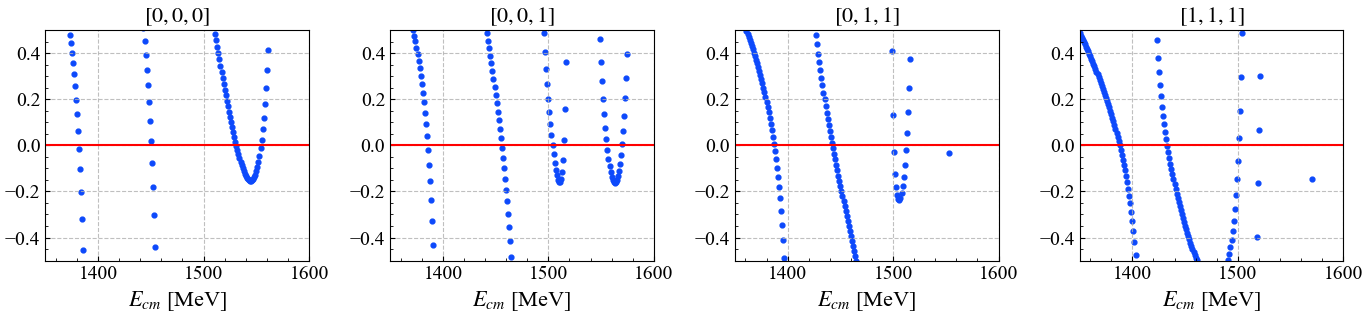

In [38]:
w = 1350:1:1600
fig, ax = PyPlot.subplots(1, 4, figsize=(14, 3.5), tight_layout=true)
title = [L"$[0,0,0]$", L"$[0,0,1]$", L"$[0,1,1]$", L"$[1,1,1]$"]
for (i, G) in enumerate([[0,0,0], [0,0,1],[0,1,1],[1,1,1]] )
    ax[i].set_title(title[i])
    @time plot_tdet_finite_vol!(ax[i], w, params, fpara[1:2], G)
end
gcf()

In [39]:
fitted_para = DataFrame(CSV.File("./out/fitted_para.csv"))


Row,name,para,para_err
,String3,Float64,Float64
1,a1,-1.79982,1.37929
2,a2,-2.0,0.157803
3,fϕ,92.9976,0.431615
4,f,1.15,0.0301707


In [40]:
fitted_a = fitted_para[!, :para][1:2]
fitted_ff = fitted_para[!, :para][3] * fitted_para[!, :para][4]

106.9471633672461

In [13]:
params[:decons_vec] = [fitted_ff, fitted_ff, fitted_ff, fitted_ff]
params

UndefVarError: UndefVarError: `fitted_ff` not defined

In [42]:
Nv = [[0,0,0], [0,0,1], [0,1,1], [1,1,1]]
df2 = pole_finite_vol_all_boost!(latt_pole, params, fitted_a, Nv)
pole2 = [df2[!, i] for i in 1:4]
df2

Row,"[0, 0, 0]","[0, 0, 1]","[0,1,1]","[1,1,1]"
,Float64,Float64,Float64,Any
1,1381.82,1385.69,1387.23,1387.97
2,1450.22,1455.73,1442.46,1432.95
3,1530.86,1504.02,1512.29,1500.7
4,1554.36,1514.78,NaN,1519.71


In [20]:
CSV.write("./out/energy_level_fitted_LO_formula.csv", df2);

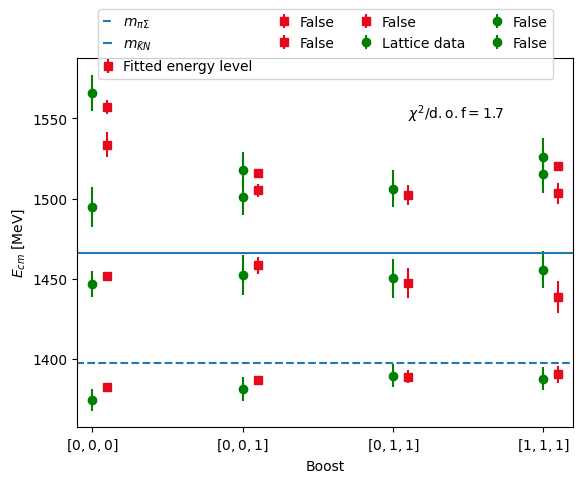

In [10]:
fig, ax = PyPlot.subplots()
plot_lv_errbar!(ax)
plot_latt_ener!(ax, latt_pole, latt_pole_err, latt_para[:threshold] )
#plot_theory_ener!(ax, pole2)
ax.legend(loc="upper center" , bbox_to_anchor=(0.5, 1.15), ncol=4, fancybox=true, handlelength=0.6)
ax.text(3.1, 1550, L"$\chi^2/\mathrm{d.o.f}=1.7$")
fig.savefig("./figure/energy_level_fitted_LO.pdf")
gcf()

In [12]:
params

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

In [11]:
dim = 50
rew = range(1380, 1470, dim)
imw = range(-90, 90, dim)
a = [fitted_a[1:2]..., -2, -2]
fig, ax = PyPlot.subplots(1, 2, figsize=(9, 3.5), layout="constrained")
plot_tdet_LO!(ax[1], rew, imw, params, a, n=2, μ_tuple=(630e0,), rs="rs21")
cf = plot_tdet_LO!(ax[2], rew, imw, params, a, n=4, μ_tuple=(630e0,), rs="rs2111")
clb = fig.colorbar(cf, ax=[ax[1], ax[2]])
clb.ax.set(xlabel=L"\geq 0", ylabel=L"$|\mathrm{Det}[I-VG]|$")
clb.set_ticks([])
fig.savefig("./figure/Lambda1405_LO_2ch_4ch.pdf")
gcf()

UndefVarError: UndefVarError: `fitted_a` not defined

In [46]:
params

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [106.947, 106.947, 106.947, 106.947]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

In [47]:
init_x1 = [1382e0, -45e0]
pole_LO_RS_2ch!(init_x1, params, fitted_a)

Row,RS,pole
,String,Any
1,rs11,NaN+NaN*im
2,rs21,1409.9-56.789im
3,rs12,1435.08+10.9803im
4,rs22,1426.48-128.936im


In [48]:
init_x2 = [1477e0, -10e0]
pole_LO_RS_2ch!(init_x2, params, fitted_a)

Row,RS,pole
,String,Any
1,rs11,NaN+NaN*im
2,rs21,1463.13-17.5122im
3,rs12,1435.08-10.9803im
4,rs22,NaN+NaN*im


In [14]:
para1sigma = DataFrame(CSV.File("./out/resonable_1σ_fitted_params.csv"));
best_fitted_para = DataFrame(CSV.File("./out/fitted_para.csv"))

Row,name,para,para_err
,String3,Float64,Float64
1,a1,-1.79982,1.37929
2,a2,-2.0,0.157803
3,fϕ,92.9976,0.431615
4,f,1.15,0.0301707


In [15]:
params

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

In [17]:
function pole_LO_4ch!(params, para1sigma::DataFrame, best_fitted_para; ch="2111", a34=[-2e0, -2e0], a_phy=true)
    repLv, impLv, repHv, impHv = [], [], [], []
    params_copy = copy(params)
    for (a1, a2, fϕ, f) in zip(para1sigma.a1, para1sigma.a2, para1sigma.fϕ, para1sigma.f)
        decons = [fϕ, fϕ, fϕ, fϕ] .* f
        params_copy[:decons_vec] = decons

        repL, impL = pole_LO!([1390e0, 40e0], params_copy, [a1, a2, a34...], n=4, rs="rs2111")
        repH, impH = pole_LO!([1460e0, 10e0], params_copy, [a1, a2, a34...], n=4, rs="rs2111")
        if [repL, impL] != ["nan", "nan"] && [repH, impH] != ["nan", "nan"]
            append!(repLv, repL)
            append!(impLv, impL)

            append!(repHv, repH)
            append!(impHv, impH)
        end
    end
    ba1, ba2, bfϕ, bf = best_fitted_para.para
    best_params = copy(params)
    best_params[:decons_vec] = [bfϕ, bfϕ, bfϕ, bfϕ] .* bf
    
    bpL = abs.(pole_LO!([1390e0, 40e0], best_params, [ba1, ba2, a34...], n=4, rs="rs2111") )
    bpH = abs.(pole_LO!([1466e0, 10e0], best_params, [ba1, ba2, a34...], n=4, rs="rs2111") )

    impLv, impHv = abs.(impLv), abs.(impHv)
    # Higher pole
    repH_upper = maximum(repHv) - bpH[1]
    repH_lower = bpH[1] - minimum(repHv)

    impH_upper = maximum(impHv) - bpH[2]
    impH_lower = bpH[2] - minimum(impHv)

    # Lower pole
    repL_upper = maximum(repLv) - bpL[1]
    repL_lower = bpL[1] - minimum(repLv)

    impL_upper = maximum(impLv) - bpL[2]
    impL_lower = bpL[2] - minimum(impLv)

    df_pH = DataFrame(repH=repHv, impH=impHv)
    df_pL = DataFrame(repL=repLv, impL=impLv)
    df_pole_err = DataFrame(pH=bpH, pH_lower_upper=[(repH_lower, repH_upper), (impH_lower, impH_upper) ], pL=bpL, pL_lower_upper=[(repL_lower, repL_upper), (impL_lower, impL_upper) ])

    if a_phy == true
        CSV.write("./out/pH_LO_4ch_1sigma_a_phy.csv", df_pH)
        CSV.write("./out/pL_LO_4ch_1sigma_a_phy.csv", df_pL)
        CSV.write("./out/best_pole_LO_4ch_a_phy.csv", df_pole_err)
    else
        CSV.write("./out/pH_LO_4ch_1sigma.csv", df_pH)
        CSV.write("./out/pL_LO_4ch_1sigma.csv", df_pL)
        CSV.write("./out/best_pole_LO_4ch.csv", df_pole_err)
    end
end
pole_LO_4ch!(params, para1sigma, best_fitted_para)

"./out/best_pole_LO_4ch_a_phy.csv"